# Multithreaded Cityblock distance matrix function with SciPy and Dask's delayed execution

In this notebook we implement a function to compute the cityblock distance matrix using `scipy.spatial.distance.cdist`. Althought this function is quite fast, it uses a single thread. In cases like this one, it might be convenient to implement a multithreaded version of the function by parallelicing the execution over chunks of data. We are going to use `dask.delayed` to do that.

In [1]:
import numpy as np
from scipy.spatial.distance import cdist
from dask import compute, delayed, visualize

In [2]:
nsamples = 12000
nfeat = 50

x = 10. * np.random.random([nsamples, nfeat])

Let's time the `cdist` function and look the `top` command.

In [3]:
# observe here that the funcion `cdist` used to get the cityblock distance
# is not multithreaded

%timeit cdist(x, x, 'cityblock')

3.96 s ± 231 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


With the `top` command we see that `cdist` runs in a single thread. In such cases it could be quite simple write a distributed version of the function. We can do this very easily with `dask.delayed`!

## Dask's async delayed execution
A simple distributed version of `cdist` can be done as the following:
  * Split the array of vectors into chunks. We can use `np.split(x, num_chunks)`
  * Compute partial cityblock distance matrices of the complete array with respect to each of the chunks
  * Concatenate the resulting list into a single cityblock distance matrix.

Note that concatenation is not a fast operation, so probably we will have to continue improving our function.

In [4]:
# define the list of operations to be performed asynchronously
chunks = 12  # we choose on chunk for physical cpu (gpu partition)
partial_distances = [delayed(cdist)(x, xi, 'cityblock') for xi in np.split(x, chunks)]

# at this point nothing is executed

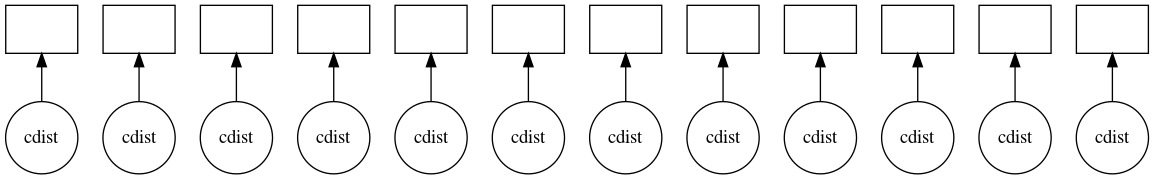

In [5]:
# visualize the copmutational graph
visualize(partial_distances)

In [6]:
cbdm_dask = delayed(np.concatenate)(partial_distances, axis=1)

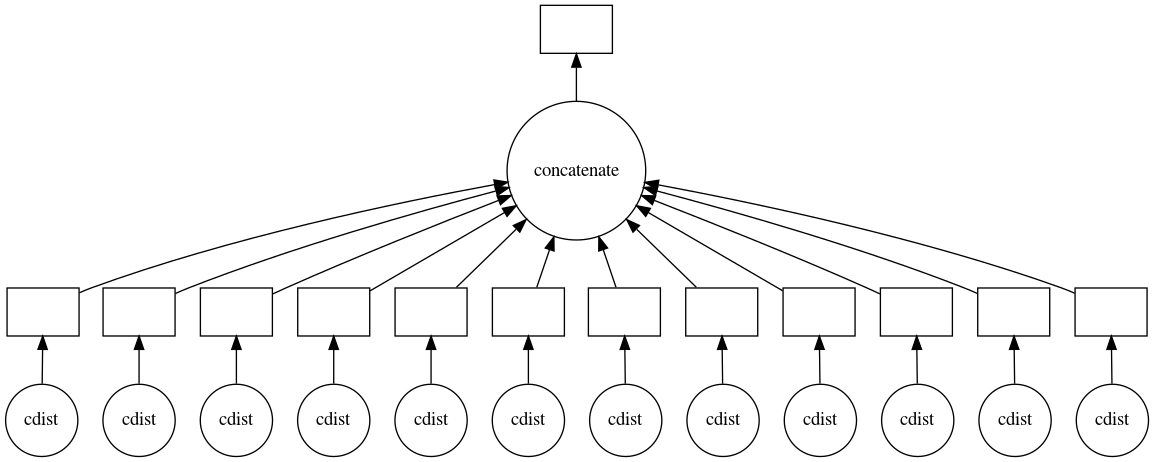

In [7]:
# visualize the copmutational graph
visualize(cbdm_dask)

Let's time the compute step and go to the command `top`. Now you can see that computation is executed in parallel resulting in a shorter execution time.

In [8]:
%timeit compute(cbdm_dask, scheduler='threads')

1.8 s ± 58.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
# check that the resulting matrices are the same
cbdm = compute(cbdm_dask, scheduler='threads')[0]
np.abs(cbdm - cdist(x, x, 'cityblock')).max()

0.0

A problem with this solution, as mentioned above, is that `np.concatenate` is not  a fast operation.
Let's check how much time it takes without the concatenation part:

In [10]:
%timeit compute(*partial_distances, scheduler='threads')

1.64 s ± 132 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's implement the whole thing as a single function:

In [11]:
def cityblock_dask_concat(x, y, chunks):
    """Implementation using array concatenation"""
    partial_distances = [delayed(cdist)(x, xi, 'cityblock')
              for xi in np.split(x, chunks)]
    cbdm_dask = delayed(np.concatenate)(partial_distances, axis=1)
    return compute(cbdm_dask, scheduler='threads')

In [12]:
print(np.abs(cityblock_dask_concat(x, x, chunks) - cdist(x, x, 'cityblock')).max())

0.0


# Conclusions
The main points to take home from this notebook are:
  * Dask's delayed execution can be used to make distributed version of functions that run on a single thread.
  * Ditributed version of functions that use OpenMP threads might be slower than the original since the CPU threads need be shared between the concurrent executions of the function.